# APMTH 207: Advanced Scientific Computing:
## Stochastic Methods for Data Analysis, Inference and Optimization
## Solutions to Homework #7
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 9th, 2018 at 11:00am

**Instructions:**

- Upload your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Gibbs Sampling On A Bivariate Normal

Let $\mathbf{X}$ be a random variable taking values in $\mathbb{R}^2$. That is, $\mathbf{X}$ is a 2-dimensional vector. Suppose that $\mathbf{X}$ is normally distributed as follows
$$ 
\mathbf{X} \sim \mathcal{N} \left(  
\left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right],
\left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right] \right).
$$ 
That is, the pdf of the distribution of $\mathbf{X}$ is
$$
f_{\mathbf{X}}(\mathbf{x}) = \frac{1}{2\pi\sqrt{\vert \Sigma\vert }}\mathrm{exp}\left\{ - \frac{1}{2} (\mathbf{x} - \mu)^\top \Sigma^{-1} (\mathbf{x} - \mu)\right\}
$$
where $\mu = \left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right]$, $\Sigma = \left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right]$, and $\vert \cdot\vert $ is the matrix determinant operator.

In the following, we will denote the random variable corresponding to the first component of $\mathbf{X}$ by $X_1$ and the second component by $X_2$.

* Write a Gibbs sampler for this distribution by sampling sequentially from the two conditional distributions $f_{X_1\vert X_2}, f_{X_2\vert X_1}$. 
* Choose a thinning parameter, burn-in factor and total number of iterations that allow you to take 10000 non-autocorrelated draws. 
* You must justify your choice of parameters. 

**Solutions**



Given a bivariate normal distribution with $\mu = [\mu_X, \mu_Y]$ and $\Sigma = \left[\begin{array}{cc}\sigma^2_X & \rho\sigma_X\sigma_Y\\\rho\sigma_X\sigma_Y & \sigma^2_Y\end{array}\right]$. The conditionals $p(Y | X)$ and $p(X | Y)$ are both normal with:
\begin{align}
\mathbb{E}[Y|x] &= \mu_Y + \rho\frac{\sigma_Y}{\sigma_X}(X - \mu_X), &\text{Var}[Y|x] = \sigma_Y^2(1 - \rho)\\
\mathbb{E}[X|y] &= \mu_X + \rho\frac{\sigma_X}{\sigma_Y}(Y - \mu_Y), &\text{Var}[X|y] = \sigma_X^2(1 - \rho)
\end{align}

In our case, we have $\mu_X = 1, \mu_Y = 2$, $\sigma_X = \sigma_Y = 2$. Then we have $\rho = \frac{\text{Cov}[X, Y]}{\sigma_X\sigma_Y} = \frac{1.2}{4} = 0.3$.

In [6]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import uniform
from scipy.stats import gamma
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd

#all the parts in the bivariate dist
sigma_x = 2
sigma_y = 2
rho = 0.3
mu_x = 1
mu_y = 2

p_x = lambda y: np.random.normal(mu_x + rho * sigma_x / sigma_y * (y - mu_y), sigma_x**2 * (1 - rho), 1)[0]
p_y = lambda x: np.random.normal(mu_y + rho * sigma_y / sigma_x * (x - mu_x), sigma_y**2 * (1 - rho), 1)[0]

def gibbs(p_x, p_y, iters, x_0, y_0, burn, thin=1):
    old_x = x_0
    old_y = y_0
    samples = [[old_x, old_y]]
    for i in range(iters):
        new_x = p_x(old_y)
        new_y = p_y(old_x)
        samples.append([new_x, new_y])
        
    return np.array(samples[int(burn * iters)::thin])

4501


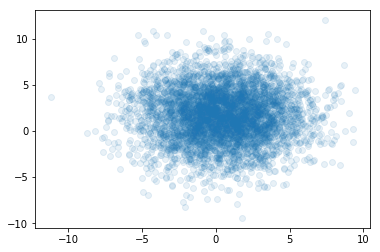

In [3]:
x_0 = 0
y_0 = 0
iters = 5000
burn = .1
samples = gibbs(p_x, p_y, iters, x_0, y_0, burn)
print(len(samples))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1)

## Problem 2: Rubber Chickens Bawk Bawk!
In the competitive rubber chicken retail market, the success of a company is built on satisfying the exacting standards of a consumer base with refined and discriminating taste. In particular, customer product reviews are all important. But how should we judge the quality of a product based on customer reviews?

On Amazon, the first customer review statistic displayed for a product is the ***average rating***. The following are the main product pages for two competing rubber chicken products, manufactured by Lotus World and Toysmith respectively:


Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018spring/homework/lotus1.png) |  ![alt](https://am207.github.io/2018spring/homework/toysmith1.png)

Clicking on the 'customer review' link on the product pages takes us to a detailed break-down of the reviews. In particular, we can now see the number of times a product is rated a given rating (between 1 and 5 stars).

Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018spring/homework/lotus2.png) |  ![alt](https://am207.github.io/2018spring/homework/toysmith2.png)

(The images above are also included on canvas in case you are offline, see below)

In the following, we will ask you to compare these two products using the various rating statistics. **Larger versions of the images are available in the data set accompanying this notebook**.

Suppose that for each product, we can model the probability of the value each new rating as the following vector:
$$
\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]
$$
where $\theta_i$ is the probability that a given customer will give the product $i$ number of stars.


### Part A: Inference

1. Suppose you are told that customer opinions are very polarized in the retail world of rubber chickens, that is, most reviews will be 5 stars or 1 stars (with little middle ground). Choose an appropriate Dirichlet prior for $\theta$. Recall that the Dirichlet pdf is given by:
$$
f_{\Theta}(\theta) = \frac{1}{B(\alpha)} \prod_{i=1}^k \theta_i^{\alpha_i - 1}, \quad B(\alpha) = \frac{\prod_{i=1}^k\Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^k\alpha_i\right)},
$$
where $\theta_i \in (0, 1)$ and $\sum_{i=1}^k \theta_i = 1$, $\alpha_i > 0 $ for $i = 1, \ldots, k$.

2. Write an expression for the posterior pdf, using a using a multinomial model for observed ratings. Recall that the multinomial pdf is given by:
$$
f_{\mathbf{X}\vert  \Theta}(\mathbf{x}) = \frac{n!}{x_1! \ldots x_k!} \theta_1^{x_1} \ldots \theta_k^{x_k}
$$
where $n$ is the total number of trials, $\theta_i$ is the probability of event $i$ and $\sum_i \theta_i = 1$, and $x_i$ is count of outcome $i$ and $\sum_i x_i = n$. 

  **Note:** The data you will need in order to define the likelihood function should be read off the image files included in the dataset.
  

3. Sample 1,000 values of $\theta$ from the *posterior distribution*.
 
4. Sample 1,000 values of $x$ from the *posterior predictive distribution*.


### Part B: Ranking

1. Name at least two major potential problems with using only the average customer ratings to compare products.

  (**Hint:** if product 1 has a higher average rating than product 2, can we conclude that product 1 is better liked? If product 1 and product 2 have the same average rating, can we conclude that they are equally good?)
  

2. Using the samples from your *posterior distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

3. Using the samples from your *posterior predictive distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

4. Finally, which rubber chicken product is superior?

  (**Note:** we're not looking for "the correct answer" here, any sound decision based on a statistically correct interpretation of your model will be fine)

**Solutions:**


### Part A

The Bayesian model for each product is as follows:
\begin{aligned}
p(\theta) &= \text{Dirichlet}(\theta; \alpha)\\
p(X|\theta)&= \text{Multinomial}(X; n, \theta)
\end{aligned}
where $\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]$, $\alpha = [\alpha_1, \alpha_2, \alpha_3, \alpha_4, \alpha_5]$ and $X = [X_1, X_2, X_3, X_4, X_5]$. Each $X_i$ is the number of times the product is given $i$-number of stars, each $\theta_i$ is the "likelihood" that any customer will give the product $i$-number of stars, and $\alpha_i$ is the hyperparameter controlling the "likelihood" that a larger value for $\theta_i$ is drawn.

This model models two parts:

1. The prior - here we assume that each product has a secret quality rating - this is a distribution over 1 thru 5 stars (for example, [1, 0, 0, 0, 0] might indicate that the product isn't very good). This quality rating is unknown to us. The prior represents what we believe the secret quality rating to be. So, for example, $\alpha = [1000, 1, 1, 1, 1]$ represents the (very strong) belief that this product is very poor (more specifically, when $\alpha >0$ it represents a vector of pseudo-counts, as if this these are ratings you already have prior to collecting your data).

2. The likelihood - this describes the data we actually see (i.e. the counts, how many of 5 stars and how many of 4 stars etc). Here we assume that each customer reviews the product independently and the way they do it is via the "secret quality rating" $\theta$. That is, if the secret rating of the product is $[.9, 0, 0, 0, .1]$, then there is a 90% chance that any customer will rank the product 1-star and a 10% chance that they will rank it 5 stars. Thus, each customer review is a mulinoulli or categorical trial and the total review data (the counts) can be described as a multinomial model.

Ok, so since apparently the ducks are polarizing, we'll choose the following alphas: $\alpha = [1000, 10, 10, 10, 1000]$. This is a pretty strong belief.

Then either you do some algebra or look this up. You get that the posterior is a Dirichlet, with $\alpha_{posterior} = [\alpha_1 + \text{number of 1 stars}, ..., \alpha_5 + \text{number of 5 stars}]$ and the posterior predictive is a multimoulli/categorical trial, with $\theta_i = \frac{\text{(number of i stars)} + \alpha_i}{\sum_k\text{(number of k stars)} + \alpha_k }$.

To sample from Dirichlet is easy - just go get it.

To sample from posterior predictive you can:
 
- feed the posterior samples of $\theta$ into likelihood to get new x's
- generate x's directly from the categorical class probabilities

In [5]:
alpha = [10000, 10, 10, 10, 10000]
counts_lotus = [109, 27, 10, 6, 10]
counts_toysmith = [246, 45, 29, 33, 57]

posterior_samples = np.random.dirichlet(np.array(alpha) + np.array(counts_lotus), 1000)
posterior_mean = posterior_samples.mean(axis=0)
print('lotus posterior mean:', posterior_mean)

posterior_samples = np.random.dirichlet(np.array(alpha) + np.array(counts_toysmith), 1000)
posterior_mean = posterior_samples.mean(axis=0)
print('toysmith posterior mean:', posterior_mean)

lotus posterior mean: [0.50061748 0.00183795 0.0010031  0.00078485 0.49575661]
toysmith posterior mean: [0.5012617  0.00267634 0.00190568 0.00209284 0.49206344]


In [6]:
predictive_mean = (np.array(alpha) + np.array(counts_lotus)) * 1. / (np.array(alpha) + np.array(counts_lotus)).sum()
print('lotus posterior mean:', predictive_mean)

predictive_mean = (np.array(alpha) + np.array(counts_toysmith)) * 1. / (np.array(alpha) + np.array(counts_toysmith)).sum()
print('toysmith posterior mean:', predictive_mean)

lotus posterior mean: [0.50064382 0.00183241 0.00099049 0.00079239 0.49574089]
toysmith posterior mean: [0.50127202 0.0026908  0.00190802 0.00210372 0.49202544]


### Part B

The questions here were pretty subjective, so we won't provide definitive answers in the solutions.  Rather we'll leave you somethings to think about 

**Things to Think About**

1. Note that the posterior mean is not the same as the posterior predictive mean!!! In this case they both give similar distributions. Now there is a whole school of debate about which is better (posterior or posterior predictive) for making decisions, so go read about it!

2. If you fix a distribution (either posterior or posterior predictive), you still need to decide what it means to be a better product.  There are obvious problems with a discriminative point statistic like average or median. Should you average all the customer reviews - this is dangerous b/c then you can't tell the difference between a product with 10 5-stars and 10 1 stars vs a product with 20 3-star reviews. In this case, both products have somewhat similar distributions over stars so make a reasonable decision!

## Problem 3:  Implementing Rat Tumors in pymc3

(it may help to see the bioassay lab to see how to structure pymc3 code, and also the examples from lecture).

Let us try to do full Bayesian inference with PyMC3 for the rat tumor example that we have solved using explicit Gibbs sampling in lab7. Remember that the goal is to estimate $\theta_i$, the probability of developing a tumor in a population of female rats that have not received treatement. 

The posterior for the 70 experiments may be written thus:

$$p( \{\theta_i\}, \alpha, \beta  \vert  Y, \{n_i\}) \propto p(\alpha, \beta) \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta) \prod_{i=1}^{70} Binom(n_i, y_i, \theta_i)$$

Use uniform priors on $[0,1]$ on the alternative variables $\mu$ (the mean of the beta distribution) and $\nu$:

$$\mu = \frac{\alpha}{\alpha+\beta}, \nu = (\alpha+\beta)^{-1/2}$$

You may then write $\alpha$ and $\beta$ as deterministics which depend on $\mu$ and $\nu$.

Here is the data:

In [7]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""

### Part A:  Report at least the following diagostics on your samples

1. Autocorrelation (correlation dying by lag 20 is fine)
2. Parameter trace correlation after burnin
3. Gewecke
4. Gelman-Rubin
5. $n_{eff}$ (Number of Effective Samples)

### Part B:  Posterior predictive check

Recall from lab notes that in a hierarchical model there are two kinds of posterior predictions that are useful. (1) The distribution of future observations $y_i^*$  given a $\theta_i$, and (2) The distribution of observations $y_j^*$  drawn from a future $\theta_j$ drawn from the super-population (i.e. using the Beta on the estimated hyper parameters).

1. Carry out posterior predictive checks by using `sample_ppc` to generate posterior-predictives for all 70 experiments. This generates predictives of the first type above. 

2. Plot histograms for these predictives with the actual value shown as a red-dot against the histogram (as in the coal disasters model in lecture 14). Is the data consistent with the predictive?

### Part C:  Shrinkage

1. Plot the posterior median of the death rate parameters $\theta_1, \theta_2, ...\theta_{70}$ against the observed death rates ($y_i/n_i$)

2. Explain the shrinkage by comparing against a 45 degree line as done in the lab.

### PART D:  Experiment 71

Consider an additional experiment -- experiment 71 -- in which 4 out of 14 rats died. 

1. Calculate the marginal posterior of $\theta_{71}$, the "new" experiment,

2. Find the $y_{71}^*$ posterior predictive for that experiment.

**HINT: ** The critical thing to notice is that the posterior including the 71st experiment factorizes:

$$p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)  \propto p(y_{71} \vert n_{71}, \theta_{71} ) p(\theta_{71} \vert \alpha, \beta) p(\theta_{1..70}, \alpha, \beta \vert  D)$$

Then we simply marginalize over everything to get the $\theta_{71}$ posterior:

$$p(\theta_{71} \vert \theta_{1..70}, \alpha, \beta, D) = \int d\alpha \,d\beta \,d\theta_{1..70} \,p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)$$

$$=  \int d\alpha \,d\beta  Beta(\alpha+y_{71}, \beta + n_{71} - y_{71})  \int_{\theta_{1..70}} \,d\theta_{1..70} \,p(\theta_{1..70}, \alpha, \beta \vert  D)$$

The $y_{71}^*$ posterior predictive can be found in the usual way.

**Solutions**:

We'll start by creating two arrays, one for the observed tumors and one for the total number of rats in each of the 70 experiments.

In [8]:
tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])
print(tumory, tumorn)
print(np.shape(tumory))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  3  2
  2  2  2  2  2  2  2  2  1  5  2  5  2  7  7  3  3  2  9 10  4  4  4  4
  4  4  4 10  4  4  4  5 11 12  5  5  6  5  6  6  6  6 16 15 15  9] [20 20 20 20 20 20 20 19 19 19 19 18 18 17 20 20 20 20 19 19 18 18 27 25
 24 23 20 20 20 20 20 20 10 49 19 46 17 49 47 20 20 13 48 50 20 20 20 20
 20 20 20 48 19 19 19 22 46 49 20 20 23 19 22 20 20 20 52 46 47 24]
(70,)


Just to have some intuition let us get the naive probabilities ($y_i/n_i$) of developing a tumor for each of the 70 experiments, and let's print the mean and the standard deviation:

In [9]:
tumor_rat = [float(e[0])/float(e[1]) for e in zip(tumory, tumorn)]
#print (tumor_rat)
tmean = np.mean(tumor_rat)
tvar = np.var(tumor_rat)
print(tmean, tvar)

0.13600653889043893 0.010557640623609196


### Setting up the PyMC3 model

Now let us set up the model. Note the simplification with respect to the Gibbs sampler we have used earlier. Because PyMC3 takes care of refining the parameters of the selected step method, or uses gradient-based methods for the sampling, it does not require us to specify the conditionals distributions for $\alpha$ and $\beta$. We only need to specify the priors for $\mu$ and $\nu$, and then write expressions for $\alpha$ and $\beta$ as a function of $\mu$ and $\nu$. Note that we use the ```pm.Deterministic``` function to define $\alpha$ and $\beta$ and give them proper names. Without a name, these variables will not be included in the trace.

In [10]:
# pymc3
import pymc3 as pm

N = tumorn.shape[0]

with pm.Model() as tumor_model:

    # Uniform priors on the mean and variance of the Beta distributions
    mu = pm.Uniform("mu",0.00001,1.)
    nu = pm.Uniform("nu",0.00001,1.)

    # Calculate hyperparameters alpha and beta as a function of mu and nu
    alpha = pm.Deterministic('alpha', mu/(nu*nu))
    beta = pm.Deterministic('beta', (1.-mu)/(nu*nu))
    
    # Priors for each theta
    thetas = pm.Beta('theta', alpha, beta, shape=N)
    
    # Data likelihood
    obs_deaths = pm.Binomial('obs_deaths', n=tumorn, p=thetas, observed=tumory)

In [ ]:
with tumor_model:
    # Use ADVI for initialization
    step = pm.NUTS()
    tumor_trace = pm.sample(5000,step, chains=2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa63a34c0f0>,
      dtype=object)

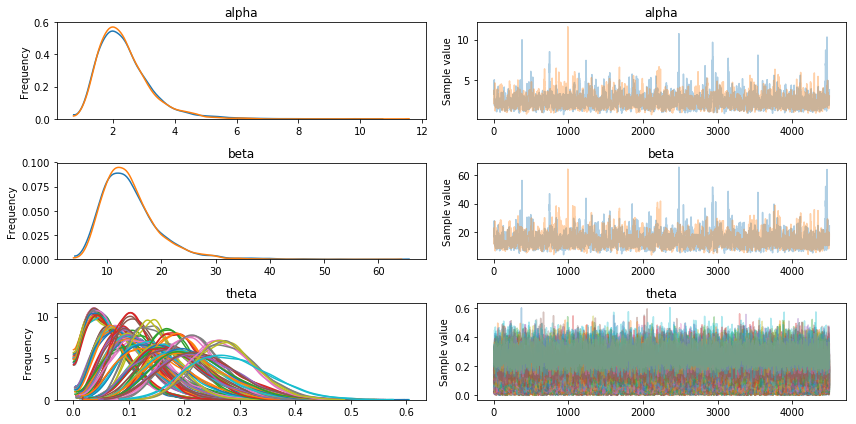

In [51]:
from pymc3 import traceplot

#traceplot(bioassay_trace[500:], varnames=['alpha'])
traceplot(tumor_trace[500:], varnames=['alpha','beta','theta'])

Text(0,0.5,'$\\log(\\alpha+\\beta)$')

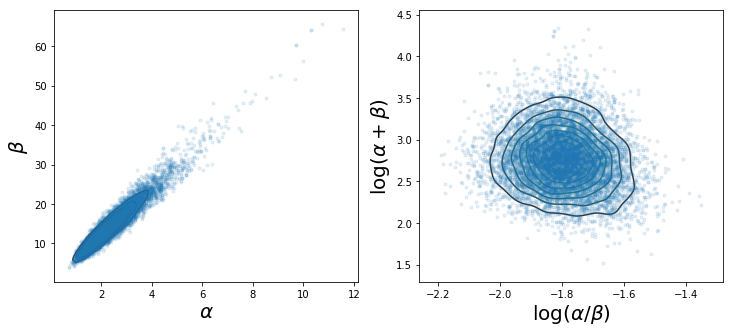

In [52]:
import seaborn as sns

fig = plt.subplots(1, 2, figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(tumor_trace['alpha'][500:], tumor_trace['beta'][500:],'.', alpha=0.1)
sns.kdeplot(tumor_trace['alpha'][500:], tumor_trace['beta'][500:])
plt.xlabel(r"$\alpha$",size=20)
plt.ylabel(r"$\beta$",size=20)
plt.subplot(1,2,2)
plt.plot(np.log(tumor_trace['alpha'][500:]/tumor_trace['beta'][500:]), np.log(tumor_trace['alpha'][500:]+tumor_trace['beta'][500:]),'.', alpha=0.1)
sns.kdeplot(np.log(tumor_trace['alpha'][500:]/tumor_trace['beta'][500:]), np.log(tumor_trace['alpha'][500:]+tumor_trace['beta'][500:]))
plt.xlabel(r"$\log(\alpha/\beta)$",size=20)
plt.ylabel(r"$\log(\alpha+\beta)$",size=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6223b6198>,
      dtype=object)

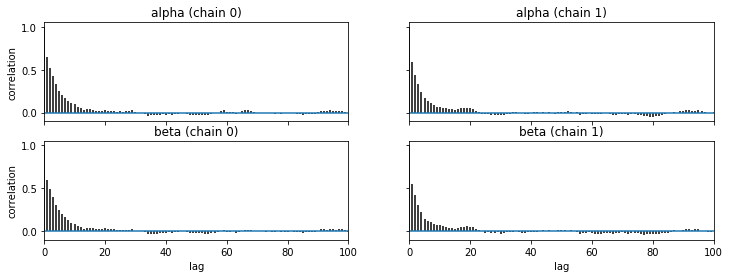

In [53]:
pm.autocorrplot(tumor_trace[500:],varnames=['alpha','beta'])

Note the advantage of using gradients for sampling (stay tuned for Hamiltonian Monte Carlo). We need way less samples to converge to a similar result as with Metropolis, and autocorrelation plots look beter. Let us move to checking convergence for the NUTS sampler, using the Geweke diagnostic. It is important to check that both $\alpha$ and $\beta$ has converged.

In [54]:
from pymc3 import geweke
z = geweke(tumor_trace[500:], intervals=15)

Text(0.5,0.98,'Gewecke Statistic for Chain 1')

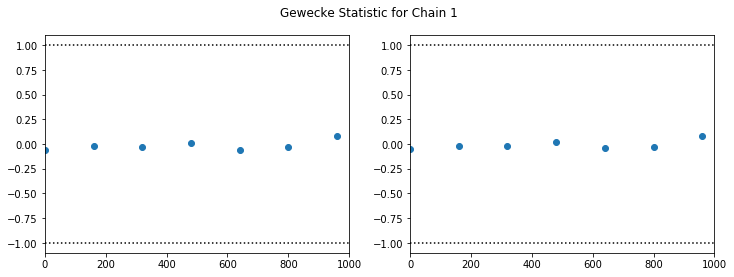

In [59]:
fig = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1,2,1)
plt.scatter(*z[0]['alpha'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)
plt.subplot(1,2,2)
plt.scatter(*z[0]['beta'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)
plt.suptitle("Gewecke Statistic for Chain 1")

Text(0.5,0.98,'Gewecke Statistic for Chain 2')

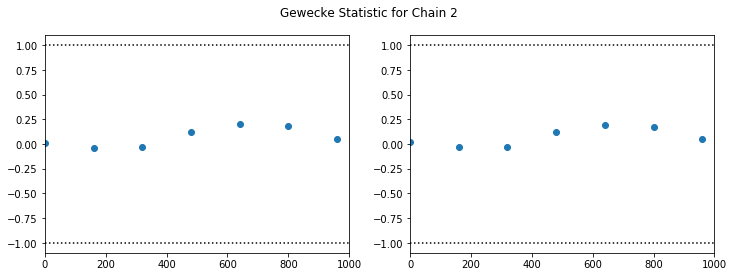

In [60]:
fig = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1,2,1)
plt.scatter(*z[1]['alpha'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)
plt.subplot(1,2,2)
plt.scatter(*z[1]['beta'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)
plt.suptitle("Gewecke Statistic for Chain 2")

In [62]:
pm.diagnostics.gelman_rubin(tumor_trace)

{'mu': 0.9999209083926891,
 'nu': 0.9999374235601804,
 'alpha': 0.9999706221200141,
 'beta': 1.0000191231399276,
 'theta': array([0.99993762, 0.99998791, 0.99993933, 0.99990004, 0.99993612,
        0.9999011 , 1.00016367, 0.99990978, 0.99992628, 1.00062522,
        1.0000085 , 1.00003099, 0.99993332, 0.99991602, 1.00019643,
        0.99992699, 0.99997886, 0.99996781, 0.99995015, 0.99990013,
        0.99990114, 0.99990048, 1.00001048, 0.99990819, 0.99990006,
        1.0002998 , 0.99991662, 0.99992476, 0.99991628, 1.0001706 ,
        1.00008167, 0.99991757, 0.99991375, 0.99997984, 0.99990011,
        0.99990355, 1.00004048, 0.99999045, 1.00001932, 0.99990305,
        0.99990553, 0.99992056, 0.99995224, 0.99991201, 1.00001538,
        1.00022171, 0.99993632, 0.99996561, 0.99992078, 0.99999333,
        0.99993484, 0.99990574, 0.9999589 , 0.9999004 , 0.99993206,
        0.99991498, 1.00011123, 0.99991734, 1.00000044, 0.99990059,
        0.99990036, 0.99995684, 0.99992002, 0.99991483, 0.9999

In [63]:
pm.diagnostics.effective_n(tumor_trace)

{'mu': 7185.0,
 'nu': 1751.0,
 'alpha': 1415.0,
 'beta': 1465.0,
 'theta': array([10000.,  7062., 10000., 10000., 10000., 10000., 10000., 10000.,
        10000., 10000., 10000.,  8210., 10000., 10000., 10000., 10000.,
        10000., 10000., 10000., 10000., 10000., 10000., 10000.,  9454.,
        10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
        10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
        10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
        10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
        10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
        10000., 10000., 10000., 10000., 10000.,  6543.])}

Our Gelman statistic is in a reasonable range (i.e. < 1.2) an our number of effective samples > 20% so while not ideal, is in an acceptable range.

### Part B

Let's sample from the posterior predictive

In [65]:
from pymc3 import sample_ppc
with tumor_model:
    tumor_sim = sample_ppc(tumor_trace[500:], samples=500)

100%|██████████| 500/500 [00:00<00:00, 3561.16it/s]


Let's plot a few of the posterior predictives and the observed data:

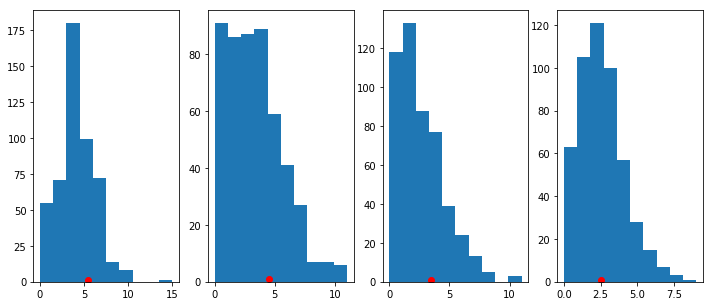

In [67]:
fig = plt.subplots(1, 4, figsize=(12, 5))
plt.subplot(1,4,1)
plt.hist(tumor_sim['obs_deaths'].T[59])
plt.plot(tumory[59]+0.5, 1, 'ro')
plt.subplot(1,4,2)
plt.hist(tumor_sim['obs_deaths'].T[49])
plt.plot(tumory[49]+0.5, 1, 'ro')
plt.subplot(1,4,3)
plt.hist(tumor_sim['obs_deaths'].T[39])
plt.plot(tumory[39]+0.5, 1, 'ro')
plt.subplot(1,4,4)
plt.hist(tumor_sim['obs_deaths'].T[29])
plt.plot(tumory[29]+0.5, 1, 'ro')

### Part C

A more meaningful plot is the observed tumor rates on the x-axis against posterior medians for each of the 70 $\theta$'s on the y axis, along with error bars obtained from finding the 2.5 and 97.5 percentiles. With ```df_summary``` we can get the summary with the means and the percentiles directly into a pandas dataframe:

In [ ]:
from pymc3 import df_summary

df_sum = df_summary(tumor_trace[500:], varnames=['theta'])

In [69]:
medianthetas = df_sum['mean'].values
lowerthetas = df_sum['hpd_2.5'].values
upperthetas = df_sum['hpd_97.5'].values

elowertheta = medianthetas - lowerthetas
euppertheta = upperthetas - medianthetas

Our naive, non-Bayesian estimate of the probabilities would have been just the ratio of rats with tumor to total number of observed rats in each experiment:

In [70]:
ratios=tumory.astype(float)/tumorn

Now let us compare those naive estimates to our posterior estimates:

(-0.1, 0.5)

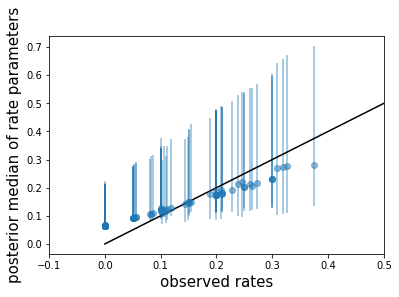

In [71]:
plt.errorbar(ratios, 
             medianthetas, yerr=[lowerthetas,upperthetas], fmt='o', alpha=0.5)
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("observed rates",size=15)
plt.ylabel("posterior median of rate parameters",size=15)

plt.xlim(-0.1,0.5)

### Part D

The 71st experiment

In a hierarchical model, there are two kinds of posterior predictions that are useful. (1) The distribution of future observations $\tilde{y}$ given a $\theta_i$, and (2) The distribution of observations $\tilde{y}$ drawn from a future $\theta_j$ drawn from the super-population (i.e. using the Beta on the estimated hyper parameters).
We wish to understand what happens for the 'future' $\theta_{71}$.
We finally, compute the posterior prediction for the 71st experiment.

To do this remember the conditional structure of our problem. $\theta_71$'s parents in the graph are $\alpha$ and $\beta$ so it suffices to sample from them (marginalize over them) to get the $\theta_71$ posterior.

$$
p(\theta_{71},\theta_{1...70},\alpha,\beta \vert D) \propto p(y_{71} \vert n_{71},\theta_{71})p(\theta_{71} \vert \alpha,\beta)p(\theta_{1...70},\alpha,\beta \vert D)
$$

In other words the full posterior so far (for the 70 experiments) becomes the new prior for experiment 71. We need to mix in a prior for θ71θ71 as well, and then the likelihoof for y71y71. Then we simply marginalize over everything to get the θ71θ71 posterior.

In [75]:
p71=np.empty((1000,3000))
combpdf=np.zeros(1000)
xra=np.linspace(0.,1.,1000)
for i in range(3000):
    p71[:,i] = sp.stats.beta.pdf(xra, tumor_trace['alpha'][500:][i]+4, tumor_trace['beta'][500:][i]+10)
for j in range(1000):
    combpdf[j] = combpdf[j] + p71[j,:].sum()
p71.shape, p71[2,:].shape

((1000, 3000), (3000,))

(-0.1, 0.6)

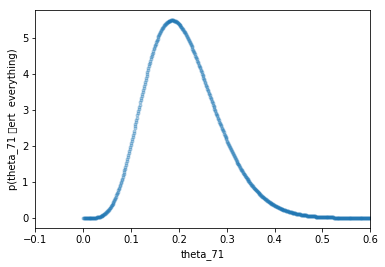

In [76]:
plt.plot(xra, combpdf/3000., '.', alpha=0.3)
plt.xlabel('theta_71')
plt.ylabel('p(theta_71 \vert  everything)')
plt.xlim([-.1,.6])

There is a very critical observation to be made in the calculation above. Notice that this posterior calculation IS NOT a bayesian updating. Neither $\theta_{1:70}$ or $\alpha$ and $\beta$ have been updated to take into account the new data. In this sense we are simply using the parameters in a non-online, supervised mode. Below we redo our MCMC with the new data to get updated parameter estimates.

In [80]:
N = tumorn.shape[0]

with pm.Model() as tumor_model_new:

    # Uniform priors on the mean and variance of the Beta distributions
    mu_new = pm.Uniform("mu_new",0.00001,1.)
    nu_new = pm.Uniform("nu_new",0.00001,1.)

    # Calculate hyperparameters alpha and beta as a function of mu and nu
    alpha_new = pm.Deterministic('alpha_new', mu_new/(nu_new*nu_new))
    beta_new = pm.Deterministic('beta_new', (1.-mu_new)/(nu_new*nu_new))
    
    # Priors for each theta
    thetas_new = pm.Beta('theta_new', alpha_new, beta_new, shape=N+1)
    
    # Data likelihood
    obs_deaths_new = pm.Binomial('obs_deaths_new', n=np.concatenate((tumorn,np.array([14])),axis=0), 
                          p=thetas_new, observed=np.concatenate((tumory,np.array([4])),axis=0))

In [ ]:
with tumor_model_new:
    # Use ADVI for initialization
    step = pm.NUTS()
    tumor_trace_new = pm.sample(10000, step)

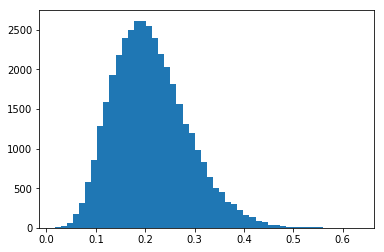

In [84]:
p71 = plt.hist(tumor_trace_new['theta_new'][1000:,70],bins=50)